# GoogLeNet (Inception v1)
GoogLeNet won the LSVRC-2014 competition. It has significant improvement over ZFNet (The winner in 2013) and AlexNet (The winner in 2012) and has relatively lower error rate compared with the VGGNet(1st runner-up in 2014).

### The highlights of the paper
- It contains 1×1 Convolution at the middle of the network. 1×1 convolution is used as a dimension reduction module to reduce the computation. By reducing the computation bottleneck, depth and width can be increased.
- Global average pooling is used at the end of the network instead of using fully connected layers. Global Average can be less prone to overfitting
- Inception module, is to have different sizes/types of convolutions for the same input and stacking all the outputs.
- Local Response Normalization

### The architecture
#### Global average pooling
![gap_layer.png](./images/gap_layer.png)
Global average pooling (GAP) layers to minimize overfitting by reducing the total number of parameters in the model. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions h×w×d is reduced in size to have dimensions 1×1×d. GAP layers reduce each h×w feature map to a single number by simply taking the average of all hw values.

#### Local Response Normalization
This layer is useful when we are dealing with ReLU neurons. Why is that? Because ReLU neurons have unbounded activations and we need LRN to normalize that. We want to detect high frequency features with a large response. If we normalize around the local neighborhood of the excited neuron, it becomes even more sensitive as compared to its neighbors. At the same time, it will dampen the responses that are uniformly large in any given local neighborhood. If all the values are large, then normalizing those values will diminish all of them. So basically we want to encourage some kind of inhibition and boost the neurons with relatively larger activations. 

#### Inception Module
<div width="100%">
    <img src="./images/inception_naive.png" width="40%">
    <img src="./images/inception_reduction.png" width="40%">
<div>
The intention is to let the neural network learn the best weights when training the network and automatically select the more useful features. Additionally, it intends to reduce the no. of dimensions so that the no. of units and layers can be increased at later stages. The side-effect of this is to increase the computational cost for training this layer. To address this, a number of solutions have been suggested in the paper such as to deploy parallel computations for this architecture.

#### Overall Architecture
GoogLeNet has 9 such inception modules stacked linearly. It is 22 layers deep (27, including the pooling layers). It uses global average pooling at the end of the last inception module. To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers. They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss.

![orignal_architech.png](./images/original_architecture.png)

# GoogLeNet implementation on Cifar 10

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_gpu_available = torch.cuda.is_available()
if is_gpu_available:
    print("Training on Gpu")
else:
    print("Training on Cpu")

Training on Gpu


## Data Loading and Preprocessing

### CIFAR10 small image classification
Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

#### Returns 2 tuples:
- **x_train, x_test**: uint8 array of RGB image data with shape (num_samples, 32, 32, 3).
- **y_train, y_test**: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).

In [3]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize

transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

train_data = CIFAR10('data', train=True, transform=transform, download=True)
test_data = CIFAR10('data', train=False, transform=transform, download=True)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = 10
print("Number of training examples =", len(train_data))
print("Number of testing examples =", len(test_data))
print("Image data shape =", train_data[0][0].shape)
print("Number of classes =", num_classes)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples = 50000
Number of testing examples = 10000
Image data shape = torch.Size([3, 32, 32])
Number of classes = 10


In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

train_length = len(train_data)
valid_size = np.int(np.floor(0.2 * train_length))
indcies = list(range(0, train_length))
np.random.shuffle(indcies)
train_idx, valid_idx = indcies[valid_size:], indcies[:valid_size]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=10, sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=10)
valid_loader = DataLoader(train_data, batch_size=10, sampler=valid_sampler)

In [5]:
def imshow(image):
    img = image.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

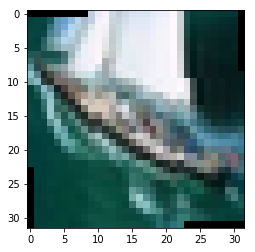

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images[0])

## Model Implementation

In [7]:
from torch.nn import Module, Conv2d, Linear, MaxPool2d, BatchNorm2d, BatchNorm1d, Dropout, Dropout2d
import torch.nn.functional as F

### Model Architecture
The entire model consists of 19 inception layers in total.
![inception_parameters.png](./images/inception_parameters.png)

In [8]:
inception_keys = {
    "3a" : {
        "input": 192,
        "1_conv": 64,
        "3_convr": 96,
        "3_conv": 128,
        "5_convr": 16,
        "5_conv": 32,
        "pool_p": 32
    },
    "3b" : {
        "input": 256,
        "1_conv": 128,
        "3_convr": 128,
        "3_conv": 192,
        "5_convr": 32,
        "5_conv": 96,
        "pool_p": 64
    },
    "4a" : {
        "input": 480,
        "1_conv": 192,
        "3_convr": 96,
        "3_conv": 208,
        "5_convr": 16,
        "5_conv": 48,
        "pool_p": 64
    },
    "4b" : {
        "input": 512,
        "1_conv": 160,
        "3_convr": 112,
        "3_conv": 224,
        "5_convr": 24,
        "5_conv": 64,
        "pool_p": 64,
    },
    "4c" : {
        "input": 512,
        "1_conv": 128,
        "3_convr": 128,
        "3_conv": 256,
        "5_convr": 24,
        "5_conv": 64,
        "pool_p": 64
    },
    "4d" : {
        "input": 512,
        "1_conv": 112,
        "3_convr": 144,
        "3_conv": 288,
        "5_convr": 32,
        "5_conv": 64,
        "pool_p": 64,
    },
    "4e" : {
        "input": 528,
        "1_conv": 256,
        "3_convr": 160,
        "3_conv": 320,
        "5_convr": 32,
        "5_conv": 128,
        "pool_p": 128
    },
    "5a" : {
        "input": 832,
        "1_conv": 256,
        "3_convr": 160,
        "3_conv": 320,
        "5_convr": 32,
        "5_conv": 128,
        "pool_p": 128
    },
    "5b" : {
        "input": 832,
        "1_conv": 384,
        "3_convr": 192,
        "3_conv": 384,
        "5_convr": 48,
        "5_conv": 128,
        "pool_p": 128
    }
}

In [9]:
class Inception(Module):
    def __init__(self, keys):
        super(Inception, self).__init__()
        self.conv1 = Conv2d(keys['input'], keys['1_conv'], 1)
        
        self.conv3r = Conv2d(keys['input'], keys['3_convr'], 1)
        self.conv3 = Conv2d(keys['3_convr'], keys['3_conv'], 3, padding=1)
        
        self.conv5r = Conv2d(keys['input'], keys['5_convr'], 1)
        self.conv5 = Conv2d(keys['5_convr'], keys['5_conv'], 5, padding=2)
        
        self.pool = MaxPool2d(3,padding=1, stride=1)
        self.conv_p = Conv2d(keys['input'], keys['pool_p'], 1)
        
    def forward(self, x):
        cn1 = F.relu(self.conv1(x))
        
        cn3 = F.relu(self.conv3r(x))
        cn3 = F.relu(self.conv3(cn3))
        
        cn5 = F.relu(self.conv5r(x))
        cn5 = F.relu(self.conv5(cn5))
        
        p1 = self.pool(x)
        p1 = self.conv_p(p1)
        
        output = [cn1, cn3, cn5, p1]
        
        return torch.cat(output,1)
        

In [10]:
class Flatten(Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [11]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_bn = BatchNorm2d(64)
        self.conv2 = Conv2d(in_channels=64, out_channels=64, kernel_size=1)
        self.conv3 = Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1)
        self.conv3_bn = BatchNorm2d(192)
        self.inception_3a = Inception(inception_keys['3a'])
        self.inception_3b = Inception(inception_keys['3b'])
        self.inception_4a = Inception(inception_keys['4a'])
        self.inception_4b = Inception(inception_keys['4b'])
        self.inception_4c = Inception(inception_keys['4c'])
        self.inception_4d = Inception(inception_keys['4d'])
        self.inception_4e = Inception(inception_keys['4e'])
        self.inception_5a = Inception(inception_keys['5a'])
        self.inception_5b = Inception(inception_keys['5b'])
        
        self.flatten = Flatten()
        
        self.fc1 = Linear(1024, 1000)
        self.fc2 = Linear(1000, 10)
        
        self.dropout = Dropout(0.4)
        self.pool = MaxPool2d(kernel_size=3, padding=1, stride=2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(self.pool(x))
        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.conv3_bn(self.pool(x))
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool(x)
        
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.pool(x)
        
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.pool(x)
        
        x = self.flatten(x)
        
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [12]:
# create a complete CNN
model = Net()
print(model)

if is_gpu_available:
    model.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inception_3a): Inception(
    (conv1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3r): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5r): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (conv_p): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (inception_3b): Inception(
    (conv1): Conv2d(256,

In [13]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training

In [14]:
# number of epochs to train the model
n_epochs = 1

valid_loss_min = np.Inf # track change in validation loss
total_train_loss = []
total_valid_loss = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.842437 	Validation Loss: 0.460609
Validation loss decreased (inf --> 0.460609).  Saving model ...


In [16]:
torch.save(model, "neutron.pt")

## Testing

In [ ]:
model.evaluate(x=x_test, y=[y_test, y_test, y_test])

In [ ]:
model.save('inception_v1_model.h5')
history = model.history

## Results
 
### Training from scratch

Training AlexNet, using stochastic gradient descent with a fixed learning rate of 0.01, for 50 epochs, we acheive a test accuracy of ~76.75%.

In accuracy and loss plot shown below, notice the large gap between the training and testing curves. This suggests that our model is overfitting.

In [ ]:
for i in history.history.keys():
    print(i)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['activation_acc'])
plt.plot(history.history['activation_1_acc'])
plt.plot(history.history['activation_2_acc'])
plt.plot(history.history['val_activation_acc'])
plt.plot(history.history['val_activation_1_acc'])
plt.plot(history.history['val_activation_2_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_S1', 'Train_S2', 'Train_S3', 'Test_S1', 'Test_S2', 'Test_S3'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Todo
- Expriment to stop model overfiting